# Interpolation Testbed Notebook

Short notebook to test various interpolation strategies. 

In [1]:
import sys 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor

import xarray as xr

In [2]:
sys.path.insert(1, '../sealsml')

In [8]:
from baseline import create_meshgrid, find_closest_values_with_indices, nanargmax_to_one, remove_zero_rows
from baseline import ScipyInterpolate, GaussianProcessInterpolator, RandomForestInterpolator

## Loading in real data

Since none of these need to be 'trained', if it works on one dataset, it will work on all of them. 

In [4]:
data = '../data/training_data_SBL2m_Ug10_src10kg_b.0.nc'

In [5]:
ds = xr.open_dataset(data)
ds

<xarray.Dataset>
Dimensions:         (variable: 8, sample: 600, sensor: 10, time: 100, mask: 2,
                     pot_leak: 20, target_time: 1, sensor_loc: 3)
Coordinates:
  * variable        (variable) object 'ref_distance' 'ref_azi_sin' ... 'q_CH4'
  * sensor_loc      (sensor_loc) object 'xPos' 'yPos' 'zPos'
Dimensions without coordinates: sample, sensor, time, mask, pot_leak,
                                target_time
Data variables:
    encoder_input   (sample, sensor, time, variable, mask) float64 ...
    decoder_input   (sample, pot_leak, target_time, variable, mask) float64 ...
    target          (sample, pot_leak, target_time) float64 ...
    sensor_meta     (sample, sensor, sensor_loc) float64 ...
    leak_meta       (sample, pot_leak, sensor_loc) float64 ...
    met_sensor_loc  (sample, sensor_loc) float64 ...

## Dataset Exploration

in this dataset, there are 600 samples.

In [6]:
sample_num = np.random.choice(ds.sample.values)
sample_num

140

#### Small Function to drop rows of zeros

In [9]:
sensor_locations = remove_zero_rows(ds.sensor_meta.isel(sample=sample_num).values)
num_of_sensors = sensor_locations.shape[0]
print('number of sensors in this sample:', num_of_sensors)

number of sensors in this sample: 6


In [10]:
print('shape of ch4 output!', ds.encoder_input.isel(sample=sample_num, sensor=slice(0, num_of_sensors), mask=0).sel(variable='q_CH4').values.shape)
ch4_data = ds.encoder_input.isel(sample=sample_num, sensor=slice(0, num_of_sensors), mask=0).sel(variable='q_CH4').values

shape of ch4 output! (6, 100)


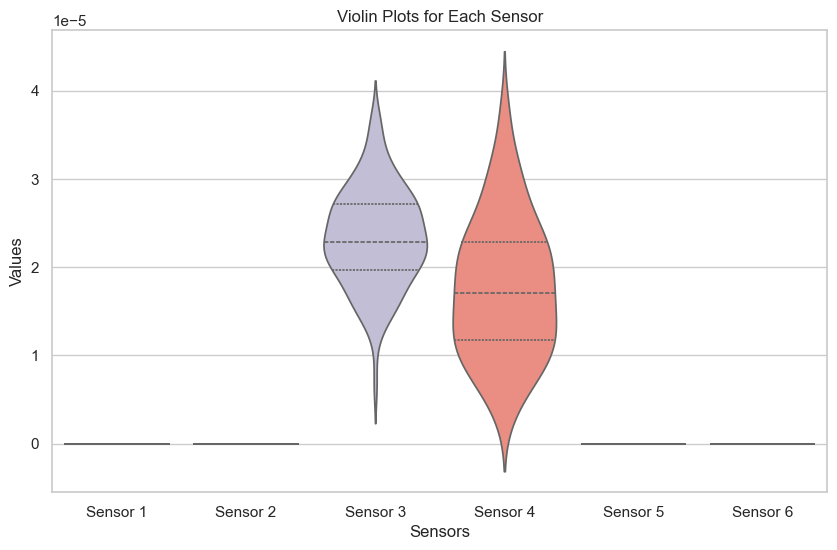

In [11]:
# Convert the NumPy array to a pandas DataFrame for Seaborn

sensor_names = [f'Sensor {i+1}' for i in range(num_of_sensors)]
#sensor_names
df = pd.DataFrame(ch4_data.T, columns=sensor_names)

# Create violin plots using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.violinplot(data=df, palette="Set3", inner="quartile")

# Set plot labels and title
plt.xlabel('Sensors')
plt.ylabel('Values')
plt.title('Violin Plots for Each Sensor')

# Show the plot
plt.show()

In [12]:
leak_locations = remove_zero_rows(ds.leak_meta.isel(sample=sample_num).values)
leak_locations

array([[8.90000000e+01, 1.99700000e+03, 1.00002539e+00],
       [9.90000000e+01, 1.99900000e+03, 1.00002539e+00],
       [1.21000000e+02, 1.99900000e+03, 1.00002539e+00],
       [1.19000000e+02, 1.99700000e+03, 1.00002539e+00],
       [1.23000000e+02, 1.99500000e+03, 1.00002539e+00],
       [1.17000000e+02, 1.98700000e+03, 1.00002539e+00],
       [9.10000000e+01, 1.98700000e+03, 1.00002539e+00],
       [1.03000000e+02, 1.99100000e+03, 1.00002539e+00],
       [1.23000000e+02, 1.96900000e+03, 1.00002539e+00],
       [1.01000000e+02, 2.01100000e+03, 1.00002539e+00],
       [1.13000000e+02, 1.97700000e+03, 1.00002539e+00],
       [9.50000000e+01, 1.97900000e+03, 1.00002539e+00],
       [1.07000000e+02, 1.99500000e+03, 1.00002539e+00],
       [1.01000000e+02, 1.99700000e+03, 1.00002539e+00],
       [1.17000000e+02, 1.97500000e+03, 1.00002539e+00],
       [1.15000000e+02, 2.00500000e+03, 1.00002539e+00]])

## Create x and y locations

#### Quick Plot

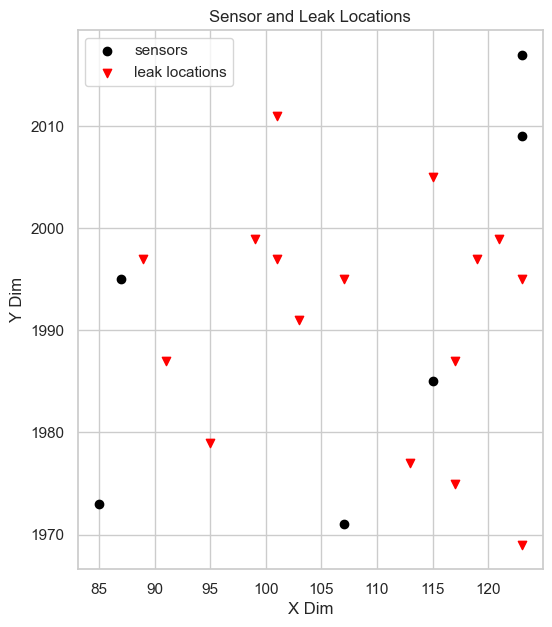

In [13]:
plt.figure(figsize=(6, 7))

plt.scatter(sensor_locations[:,0], sensor_locations[:,1], label='sensors', color='black')
plt.scatter(leak_locations[:,0], leak_locations[:,1], marker="v", label='leak locations', color='red')

plt.legend()
plt.xlabel('X Dim')
plt.ylabel('Y Dim')
plt.title('Sensor and Leak Locations')

plt.show()

In [14]:
ch4_data.shape

(6, 100)

In [15]:
ch4_median = np.median(ch4_data, axis=1)

In [16]:
len(sensor_locations[:,0]) == len(ch4_data) == len(sensor_locations[:,1])

True

## Interpolate the Data

First step is creating a new meshgrid that is more dense

In [17]:
x_new, y_new = create_meshgrid(sensor_locations[:,0], sensor_locations[:,1], buffer=20, grid_points=100)

In [18]:
x_new.shape

(100, 100)

#### Create X and y training data

In [19]:
X_train = np.column_stack((sensor_locations[:,0], sensor_locations[:,1]))
y_train = ch4_median

# new mesh data points
X_test = np.column_stack((x_new.ravel(), y_new.ravel()))
np.shape(X_test)

(10000, 2)

## SciPy Interpolator

In [20]:
scipy_model = ScipyInterpolate()
scipy_model.fit(X_train, y_train)

In [21]:
z_interpolated = scipy_model.predict(X_test)

print('type:', type(z_interpolated))
print('size:', np.shape(z_interpolated))

max_z = np.nanmax(z_interpolated)
max_indices = np.where(z_interpolated == max_z)

type: <class 'numpy.ndarray'>
size: (100, 100)


## Using Scikit-learn methods

### Gaussian Processes Regressor

In [22]:
gp_mo = GaussianProcessInterpolator()
gp_mo.fit(X_train, y_train)

/Users/thomasmartin/anaconda3/envs/py10-viz/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/thomasmartin/anaconda3/envs/py10-viz/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [23]:
reshaped_gp_results = gp_mo.predict(X_test)

print('type:', type(reshaped_gp_results))
print('size:', np.shape(reshaped_gp_results))

max_z_gp = np.nanmax(reshaped_gp_results)
max_indices_gp = np.where(max_z_gp == reshaped_gp_results)

type: <class 'numpy.ndarray'>
size: (100, 100)


#### Random Forest Model

In [24]:
rf_mo = RandomForestInterpolator()
rf_mo.fit(X_train, y_train)

In [25]:
reshaped_rf_results = rf_mo.predict(X_test)

print('type:', type(reshaped_rf_results))
print('size:', np.shape(reshaped_rf_results))

max_z_rf = np.nanmax(reshaped_rf_results)
max_indices_rf = np.where(max_z_rf == reshaped_rf_results)

type: <class 'numpy.ndarray'>
size: (100, 100)


## Find which sensor has the highest value

In [26]:
closest_values_x, indicies_x = find_closest_values_with_indices(leak_locations[:,0], x_new.diagonal())
closest_values_x

[88.63636363636364,
 98.87878787878788,
 120.93939393939394,
 119.36363636363636,
 123.3030303030303,
 117.0,
 91.0,
 102.81818181818181,
 123.3030303030303,
 101.24242424242425,
 113.06060606060606,
 94.93939393939394,
 106.75757575757575,
 101.24242424242425,
 117.0,
 114.63636363636363]

In [27]:
closest_values_y, indicies_y = find_closest_values_with_indices(leak_locations[:,1], y_new.diagonal())
closest_values_y

[1997.0404040404042,
 1998.7777777777778,
 1998.7777777777778,
 1997.0404040404042,
 1995.3030303030303,
 1986.6161616161617,
 1986.6161616161617,
 1990.9595959595958,
 1969.2424242424242,
 2010.939393939394,
 1977.060606060606,
 1978.79797979798,
 1995.3030303030303,
 1997.0404040404042,
 1975.3232323232323,
 2004.858585858586]

In [28]:
scipy_ = z_interpolated[indicies_x, indicies_y]
gp_    = reshaped_gp_results[indicies_x, indicies_y]
rf_    = reshaped_rf_results[indicies_x, indicies_y]

In [29]:
print("Which Leak location is most likely? - Using Standard Interpolator")
index_of_max_value = np.where(nanargmax_to_one(scipy_) == 1)[0][0]
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value)

Which Leak location is most likely? - Using Standard Interpolator
Index of the maximum value (ignoring NaN) is: 15


In [30]:
print("Which Leak location is most likely - Using Gaussian processes?")
index_of_max_value_gp = np.where(nanargmax_to_one(gp_) == 1)[0][0]
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value_gp)

Which Leak location is most likely - Using Gaussian processes?
Index of the maximum value (ignoring NaN) is: 15


In [31]:
print("Which Leak location is most likely - Using Random Forest?")
index_of_max_value_rf = np.where(nanargmax_to_one(rf_) == 1)[0][0]
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value_rf)

Which Leak location is most likely - Using Random Forest?
Index of the maximum value (ignoring NaN) is: 2


## Comparison Plot

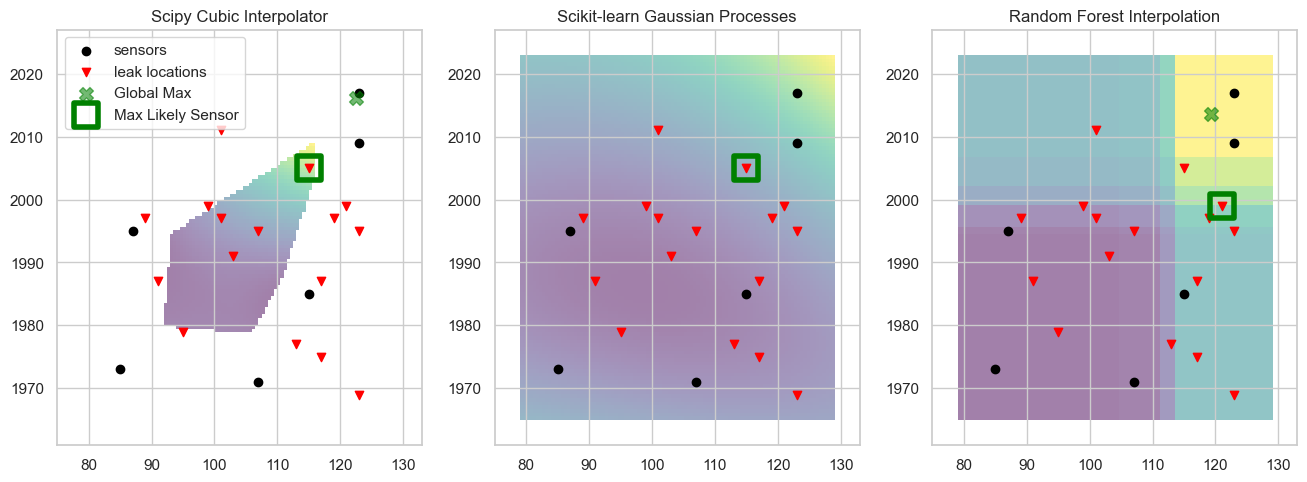

In [32]:
x_pos = sensor_locations[:,0]
y_pos = sensor_locations[:,1]

x_pos_leak = leak_locations[:,0]
y_pos_leak = leak_locations[:,1]


buffer = 6

global_min = np.round(np.min(ch4_median), 3) 
global_max = np.round(np.max(ch4_median), 3) 

fig, axes = plt.subplots(1, 3, figsize=(16, 12))

# Common settings for all subplots
for ax in axes:
    ax.scatter(x_pos, y_pos, label='sensors', color='black')
    ax.scatter(x_pos_leak, y_pos_leak, marker="v", label='leak locations', color='red')
    ax.set_xlim(min(x_pos - buffer - 4), max(x_pos + buffer + 4))
    ax.set_ylim(min(y_pos - buffer - 4), max(y_pos + buffer + 4))

# Plot 1 - First Block
img = axes[0].imshow(z_interpolated.T, extent=(min(x_pos - buffer), max(x_pos + buffer), min(y_pos - buffer), max(y_pos + buffer)),
                    origin='lower', cmap='viridis', alpha=0.5)

#img.set_clim(global_min, global_max)  # Set color bar range

axes[0].scatter(x_new[max_indices[0][0]][0], y_new[0][max_indices[1][0]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[0].scatter(x_pos_leak[index_of_max_value], y_pos_leak[index_of_max_value], marker="s", label='Max Likely Sensor', color='Green', facecolors='none', s=300, linewidths=4)
axes[0].legend()
axes[0].set_title('Scipy Cubic Interpolator')

# Plot 2 - Second Block
img2 = axes[1].imshow(reshaped_gp_results.T, extent=(min(x_pos - buffer), max(x_pos + buffer), min(y_pos - buffer), max(y_pos + buffer)),
                    origin='lower', cmap='viridis', alpha=0.5)

#img2.set_clim(global_min, global_max)

axes[1].scatter(x_pos_leak[index_of_max_value_gp], y_pos_leak[index_of_max_value_gp], marker="s", label='Max Likely Sensor', color='Green', facecolors='none', s=300, linewidths=4)
axes[1].scatter(x_new[max_indices_gp[0][0]][0], y_new[0][max_indices_gp[1][0]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[1].set_title('Scikit-learn Gaussian Processes')

# Third Across
img3 = axes[2].imshow(reshaped_rf_results.T, extent=(min(x_pos - buffer), max(x_pos + buffer), min(y_pos - buffer), max(y_pos + buffer)),
                    origin='lower', cmap='viridis', alpha=0.5)

#img3.set_clim(global_min, global_max)

axes[2].scatter(x_new[max_indices_rf[0][0]][0], y_new[0][max_indices_rf[1][0]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[2].scatter(x_pos_leak[index_of_max_value_rf], y_pos_leak[index_of_max_value_rf], marker="s", label='Max Likely Sensor', color='Green', facecolors='none', s=300, linewidths=4)
axes[2].set_title('Random Forest Interpolation')

# Add colorbar
#cbar_ax = fig.add_axes([.94, 0.25, 0.05, 0.45])  # [x, y, width, height]
#cbar = plt.colorbar(img, cax=cbar_ax)
#cbar.set_label('Z values')

# plt.tight_layout()
plt.show()

